## Loading training and validation data

We devided the training data to 2 different datasets.
- Training data: The training data will be used to train the model and recalculate the weights 
- Validation data: The validation data will be used to see the network's success on new data.

We use this method in order to prevent over fitting our model. 
The success of our model will be messured by It's preformmance on the Validation data.

* We will set rotation in order to create a larger data set.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

image_size = (256,256)
batch_size = 32

training_data_dir = r'C:\Users\Karin\Desktop\ML\Final Project\CheckData'
validation_data_dir = r'C:\Users\Karin\Desktop\ML\Final Project\CheckDataTest'

# For Google Colab:
#from google.colab import drive

#drive.mount('/gdrive')

#training_data_dir = r'/gdrive/My Drive/train'

#train_datagen = ImageDataGenerator(validation_split=0.2) # set validation split

#train_generator = train_datagen.flow_from_directory(
#    training_data_dir,
#    target_size=image_size,
#    batch_size=batch_size,
#    color_mode='rgb',
#    class_mode='categorical',
#    shuffle=True,
#    subset='training') # set as training data

#validation_generator = train_datagen.flow_from_directory(
#    training_data_dir,
#    target_size=image_size,
#    batch_size=batch_size,
#    color_mode='rgb',
#    class_mode='categorical',
#    shuffle=True,
#    subset='validation') # set as validation data





train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")


Found 2317 images belonging to 5 classes.
Found 260 images belonging to 5 classes.


## Display some of the photos

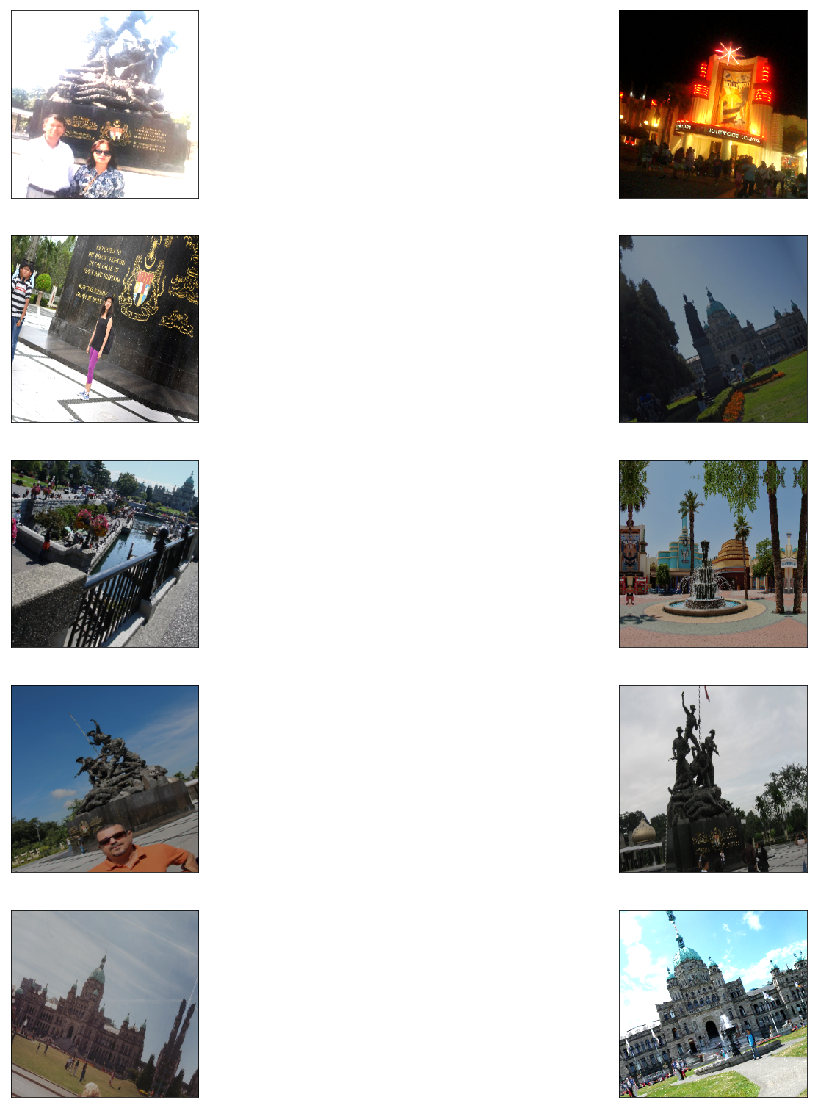

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

# Creating our model

In [3]:
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

amountOfClasses = 5;

model = Sequential()

# 1 Layer
model.add(Conv2D(64, (3,3), input_shape = (image_size[0], image_size[1], 3), padding='same'))
model.add(Activation("relu"))

# 2 Layer
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3 Layer
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation("relu"))

# 4 Layer
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 5 Layer
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Activation("relu"))

# 6 Layer
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatening the data
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))

#output layer
model.add(Dense(amountOfClasses))
model.add(Activation('softmax'))

#Show the summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
acti

## Setting the optimizer

In [4]:
import tensorflow.keras
from tensorflow.keras.optimizers import SGD
adamOptimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss = 'categorical_crossentropy', 
             optimizer= adamOptimizer,
             metrics=['accuracy'])

## Step Size

In [5]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

72


## Creating Loss and Accuracy history callbacks

In [6]:
class LossAccHisotry(Callback):
    def on_train_begin(self,logs={}):
        self.loss_history = []
        self.accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss_history.append(logs.get('val_loss'))
        self.val_accuracy_history.append(logs.get('val_acc'))
        self.loss_history.append(logs.get('loss'))
        self.accuracy_history.append(logs.get('acc'))
    
history = LossAccHisotry()## Setting the network saving time periods

# Ignoring images with a bad format

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Setting the network saving time periods

In [8]:
import time

networkfileName = r"C:\Users\Karin\Desktop\ML\Final Project\deep_NN_exp1_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

## Training the model

In [ ]:
NumberOfEpochs = 5;
ValidationSplits = 0.1;
#validation_split=ValidationSplits,

model.fit_generator(generator = train_generator,
                   steps_per_epoch= step_size_train,
                   epochs= NumberOfEpochs,
                   callbacks= [history, checkpoint],
                   validation_data= validation_generator)

Epoch 1/5


# Loss and Accuracy graphs

In [ ]:
import matplotlib.pyplot as plt
x = range(0, len(history.val_loss_history))
plt.plot(x, history.val_loss_history)
plt.plot(x, history.val_accuracy_history)
plt.xlabel('epochs')
plt.title('Validation')
plt.legend(['loss', 'accuracy'])

In [ ]:
import matplotlib.pyplot as plts
x = range(0, len(history.loss_history))
plt.plot(x, history.loss_history)
plt.plot(x, history.accuracy_history)
plt.xlabel('epochs')
plt.title('Train')
plt.legend(['loss', 'accuracy'])